In [23]:
import kagglehub

# Download the dataset
try:
    base_path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
    print("Path to dataset files:", base_path)
except Exception as e:
    print("Error downloading dataset:", e)
    exit()

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\fatihkgg\affectnet-yolo-format\versions\2


In [24]:
import os
import cv2
import glob
from tqdm import tqdm
import yaml
import csv
import uuid  # for unique filenames

def yolo_to_xyxy(label_line, img_width, img_height):
    """
    Convert YOLO label line (class_id, x_center, y_center, width, height)
    from normalized coords [0-1] to absolute pixel coords [x_min, y_min, x_max, y_max].
    """
    parts = label_line.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1]) * img_width
    y_center = float(parts[2]) * img_height
    w = float(parts[3]) * img_width
    h = float(parts[4]) * img_height

    x_min = int(x_center - w / 2)
    y_min = int(y_center - h / 2)
    x_max = int(x_center + w / 2)
    y_max = int(y_center + h / 2)

    # Clip to image boundaries
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img_width, x_max)
    y_max = min(img_height, y_max)

    return class_id, x_min, y_min, x_max, y_max


def process_split(yaml_dict, split_name, out_dir, csv_writer):
    """
    Process one split (train, valid, or test).
    - yaml_dict: loaded from data.yaml
    - split_name: 'train', 'val', or 'test'
    - out_dir: where to store all cropped images for this split (still "mixed")
    - csv_writer: CSV writer to record (filename, class_id) rows
    """

    # e.g. for train:
    images_dir = yaml_dict[split_name]         # "/kaggle/../train/images"
    labels_dir = images_dir.replace("images", "labels")

    # Collect all image paths
    img_paths = glob.glob(os.path.join(images_dir, "*.*"))  # jpg, png, etc.

    for img_path in tqdm(img_paths, desc=f"Processing {split_name}"):
        basename = os.path.basename(img_path)        # e.g. "image_12.png"
        filebase, _ = os.path.splitext(basename)     # e.g. "image_12"
        label_path = os.path.join(labels_dir, filebase + ".txt")

        if not os.path.exists(label_path):
            print(f"Label file not found for: {img_path}")
            continue  # no label, skip

        # Read the image
        image = cv2.imread(img_path)
        if image is None:
            continue  # corrupted or unreadable
        h, w, _ = image.shape

        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Each line may represent a different bounding box
        for line in lines:
            if not lines:
                print(f"Label file is empty: {label_path}")
                continue  # empty label file
            class_id, x_min, y_min, x_max, y_max = yolo_to_xyxy(line, w, h)
            crop = image[y_min:y_max, x_min:x_max]
            if crop.size == 0:
                continue  # empty crop, skip

            # Generate a unique filename so we don't overwrite
            unique_id = str(uuid.uuid4())[:8]  
            out_filename = f"{filebase}_{unique_id}.jpg"
            out_path = os.path.join(out_dir, out_filename)

            # Save the cropped face
            cv2.imwrite(out_path, crop)

            # Write a row in the CSV: [cropped_filename, class_id]
            csv_writer.writerow([out_filename, class_id])


def main():
    """
    Example usage: 
    1) Reads data.yaml
    2) Processes train, val, test
    3) Saves all cropped faces in separate 'cropped_mixed/train', 'cropped_mixed/val', 'cropped_mixed/test' dirs
    4) For each split, writes a CSV file with 'filename,class_id'
    """
    # Path to your data.yaml
    yaml_path = os.path.join(base_path, "YOLO_format/data.yaml")
    with open(yaml_path, 'r') as f:
        yaml_dict = yaml.safe_load(f)

    # Create a base output folder
    base_out = "cropped_mixed"
    os.makedirs(base_out, exist_ok=True)

    # We'll process each split separately, but keep them "mixed" (no subfolders by class)
    for split_name in ["train", "val", "test"]:
        out_dir = os.path.join(base_out, split_name)
        os.makedirs(out_dir, exist_ok=True)

        # We'll store label info in a CSV for each split
        csv_path = os.path.join(out_dir, f"{split_name}_labels.csv")
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            # Write a header row if you like
            writer.writerow(["filename", "class_id"])
            
            process_split(yaml_dict, split_name, out_dir, writer)


if __name__ == "__main__":
    main()


Processing test: 100%|██████████| 2755/2755 [00:04<00:00, 641.01it/s]


In [25]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import copy
from tqdm import tqdm

# facenet-pytorch
from facenet_pytorch import InceptionResnetV1

In [26]:
class FaceDataset(Dataset):
    def __init__(self, images_dir, csv_path, transform=None):
        """
        images_dir: folder containing cropped face images
        csv_path: CSV file with 'filename,class_id'
        transform: torchvision transforms to apply
        """
        self.images_dir = images_dir
        self.transform = transform
        self.samples = []

        with open(csv_path, 'r') as f:
            reader = csv.DictReader(f)  # handles "filename,class_id" header automatically
            for row in reader:
                fn = row['filename']
                label = int(row['class_id'])
                self.samples.append((fn, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, label = self.samples[idx]
        img_path = os.path.join(self.images_dir, filename)
        
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [27]:
class FaceNetClassifier(nn.Module):
    def __init__(self, num_emotions=8, freeze_facenet=True):
        super(FaceNetClassifier, self).__init__()
        # 1) Load FaceNet
        self.facenet = InceptionResnetV1(pretrained='vggface2').eval()
        
        if freeze_facenet:
            for param in self.facenet.parameters():
                param.requires_grad = False
        
        # 2) Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        # If facenet is in eval mode and freeze_facenet=True, it uses no_grad().
        # For partial fine-tuning, we set freeze_facenet=False & call train() on it 
        # or just manually set requires_grad to True for certain layers.
        with torch.no_grad() if not self.facenet.training else torch.enable_grad():
            embeddings = self.facenet(x)  # shape: (batch_size, 512)
        out = self.classifier(embeddings)
        return out

In [37]:
import copy
import torch
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5):
    """
    Enhanced training loop using CosineAnnealingLR:
      - Tracks train/val loss & accuracy each epoch
      - Saves best model weights based on val_acc
      - Returns model and metric lists for plotting
    """
    model = model.to(device)
    
    # LR Scheduler: CosineAnnealingLR over 'epochs' cycles
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch [{epoch+1}/{epochs}] started...")
        
        # -------- TRAIN MODE --------
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in tqdm(enumerate(train_loader),
                                               total=len(train_loader),
                                               desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------- EVAL MODE --------
        model.eval()
        val_loss_total = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss_total += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss_total / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Step the LR scheduler
        scheduler.step()
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
            print("Current LR:", current_lr)

        # Save the best model if val_acc improved
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print(f"Best val_acc across all epochs: {best_acc:.4f}")
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model + metric lists
    return model, (train_losses, train_accuracies, val_losses, val_accuracies)


Total training samples: 17101
Using device: cuda
CUDA Available: True
Starting training...
Epoch [1/15] started...


Training Epoch 1: 100%|██████████| 268/268 [01:19<00:00,  3.36it/s]


Current LR: 9.890738003669029e-05
Epoch [1/15], Train Loss: 2.0252, Train Acc: 0.2271, Val Loss: 1.7470, Val Acc: 0.3872
Epoch [2/15] started...


Training Epoch 2: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Current LR: 9.567727288213005e-05
Epoch [2/15], Train Loss: 1.5569, Train Acc: 0.4054, Val Loss: 1.3660, Val Acc: 0.4896
Epoch [3/15] started...


Training Epoch 3: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Current LR: 9.045084971874738e-05
Epoch [3/15], Train Loss: 1.3370, Train Acc: 0.4910, Val Loss: 1.1436, Val Acc: 0.5716
Epoch [4/15] started...


Training Epoch 4: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Current LR: 8.345653031794292e-05
Epoch [4/15], Train Loss: 1.2033, Train Acc: 0.5453, Val Loss: 1.0496, Val Acc: 0.6115
Epoch [5/15] started...


Training Epoch 5: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Current LR: 7.500000000000001e-05
Epoch [5/15], Train Loss: 1.1228, Train Acc: 0.5892, Val Loss: 0.9875, Val Acc: 0.6385
Epoch [6/15] started...


Training Epoch 6: 100%|██████████| 268/268 [01:19<00:00,  3.37it/s]


Current LR: 6.545084971874738e-05
Epoch [6/15], Train Loss: 1.0549, Train Acc: 0.6245, Val Loss: 0.9641, Val Acc: 0.6496
Epoch [7/15] started...


Training Epoch 7: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s]


Current LR: 5.522642316338269e-05
Epoch [7/15], Train Loss: 1.0068, Train Acc: 0.6421, Val Loss: 0.9240, Val Acc: 0.6657
Epoch [8/15] started...


Training Epoch 8: 100%|██████████| 268/268 [01:19<00:00,  3.37it/s]


Current LR: 4.4773576836617344e-05
Epoch [8/15], Train Loss: 0.9588, Train Acc: 0.6622, Val Loss: 0.9056, Val Acc: 0.6739
Epoch [9/15] started...


Training Epoch 9: 100%|██████████| 268/268 [01:19<00:00,  3.36it/s]


Current LR: 3.454915028125264e-05
Epoch [9/15], Train Loss: 0.9335, Train Acc: 0.6705, Val Loss: 0.8987, Val Acc: 0.6772
Epoch [10/15] started...


Training Epoch 10: 100%|██████████| 268/268 [01:18<00:00,  3.39it/s]


Current LR: 2.5000000000000018e-05
Epoch [10/15], Train Loss: 0.8964, Train Acc: 0.6869, Val Loss: 0.8858, Val Acc: 0.6846
Epoch [11/15] started...


Training Epoch 11: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s]


Current LR: 1.654346968205711e-05
Epoch [11/15], Train Loss: 0.8765, Train Acc: 0.6934, Val Loss: 0.8812, Val Acc: 0.6894
Epoch [12/15] started...


Training Epoch 12: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Current LR: 9.549150281252635e-06
Epoch [12/15], Train Loss: 0.8556, Train Acc: 0.7042, Val Loss: 0.8698, Val Acc: 0.6937
Epoch [13/15] started...


Training Epoch 13: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Current LR: 4.322727117869952e-06
Epoch [13/15], Train Loss: 0.8360, Train Acc: 0.7082, Val Loss: 0.8778, Val Acc: 0.6905
Epoch [14/15] started...


Training Epoch 14: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s]


Current LR: 1.092619963309716e-06
Epoch [14/15], Train Loss: 0.8269, Train Acc: 0.7146, Val Loss: 0.8794, Val Acc: 0.6903
Epoch [15/15] started...


Training Epoch 15: 100%|██████████| 268/268 [01:18<00:00,  3.39it/s]


Current LR: 0.0
Epoch [15/15], Train Loss: 0.8113, Train Acc: 0.7183, Val Loss: 0.8790, Val Acc: 0.6900
Best val_acc across all epochs: 0.6937
Training completed!


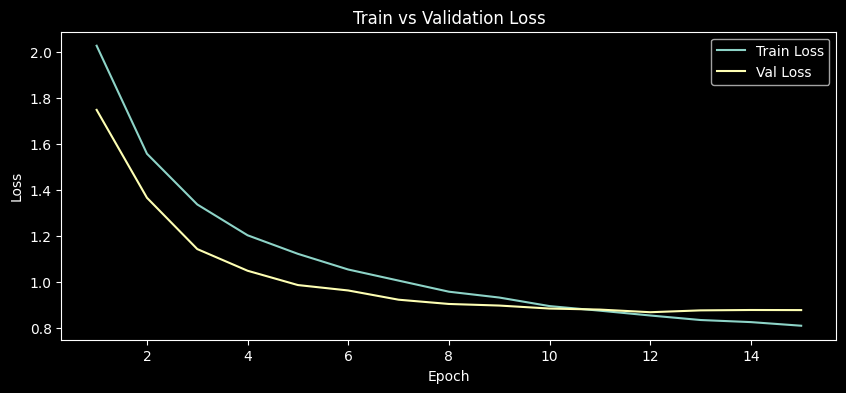

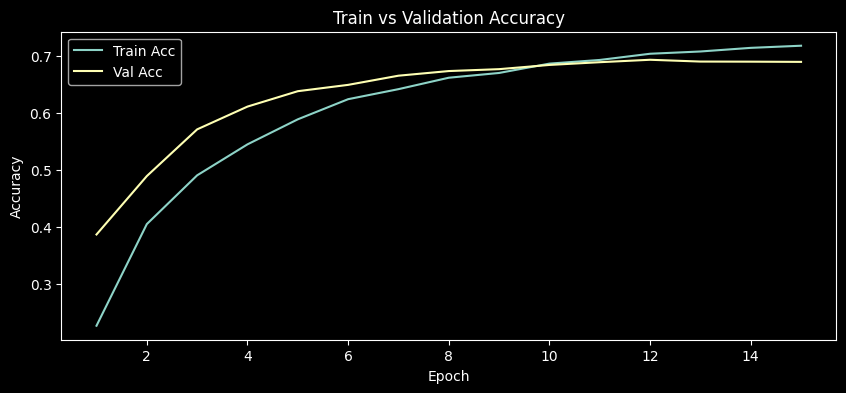

Model saved as facenet_emotion_classifier.pth


In [38]:
def main():
    # 1. Paths to your dataset
    train_dir = "cropped_mixed/train"
    train_csv = os.path.join(train_dir, "train_labels.csv")
    val_dir = "cropped_mixed/val"
    val_csv = os.path.join(val_dir, "val_labels.csv")

    # 2. Augmentations
    #    Heavier train augmentation, lighter val transform
    train_transform = transforms.Compose([
        # Example: random crop approach
        transforms.Resize((180, 180)),       # make it bigger first
        transforms.RandomCrop((160, 160)),   # then random crop to 160x160
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),
        # Random Erasing - can help generalize
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
    ])

    val_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor()
    ])

    # 3. Datasets & DataLoaders
    train_dataset = FaceDataset(train_dir, train_csv, transform=train_transform)
    val_dataset = FaceDataset(val_dir, val_csv, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    print(f"Total training samples: {len(train_loader.dataset)}")

    # 4. Initialize model, loss, optimizer, device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print("CUDA Available:", torch.cuda.is_available())
    if device == "cuda":
        print("CUDA Device Name:", torch.cuda.get_device_name(0))

    # freeze_facenet=False to allow partial or full fine-tuning
    model = FaceNetClassifier(num_emotions=8, freeze_facenet=False)

    # Example partial unfreeze
    for name, param in model.facenet.named_parameters():
        if "last_bn" in name or "block7" in name or "block8" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=1e-4
    )

    # 5. Train
    print("Starting training...")
    trained_model, metrics = train_model(
        model, criterion, optimizer, 
        train_loader, val_loader, 
        device, epochs=15
    )
    print("Training completed!")

    train_losses, train_accuracies, val_losses, val_accuracies = metrics

    # Example plotting with matplotlib
    import matplotlib.pyplot as plt

    epochs_range = range(1, len(train_losses)+1)

    # Plot Loss
    plt.figure(figsize=(10,4))
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10,4))
    plt.plot(epochs_range, train_accuracies, label='Train Acc')
    plt.plot(epochs_range, val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.show()


    # 6. Save your best model
    torch.save(trained_model.state_dict(), "facenet_emotion_classifier.pth")
    print("Model saved as facenet_emotion_classifier.pth")

if __name__ == "__main__":
    main()

# Example:
# Unfreeze the last few layers of FaceNet
for name, param in model.facenet.named_parameters():
    # if 'last_block' in name:
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def predict_single_image(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
    ])
    x = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(x)
        _, pred = torch.max(logits, 1)
    return pred.item()


In [ ]:
EMOTION_NAMES = ["Anger","Contempt","Disgust","Fear","Happy","Neutral","Sad","Surprise"]
idx = predict_single_image(trained_model, "/path/to/image.jpg", device)
emotion_label = EMOTION_NAMES[idx]
print("Predicted emotion:", emotion_label)


NameError: name 'trained_model' is not defined